# Code of Project

In [6]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import time

In [35]:
class LassowithCG:
    """
    The optimization problem of LASSO is 
        1/(2*n) * ||y-Xw||^2_2 + alpha * ||w||_1
    """
    def __init__(self, alpha=1.0, fit_intercept=True, normalize=False,
                copy_X=True, max_iter=1000, tol=1e-5, selection='cyclic'):
        self._alpha = alpha
        self._fit_intercept = fit_intercept
        self._normalize = normalize
        self._copy_X = copy_X
        self._max_iter = max_iter
        self._tol = tol
        self._selection = selection
        
        if normalize:
            self._scaler = preprocessing.StandardScaler()
            
    def compute_step(self, k, X, y, coef, intercept, alpha):
        n, p = X.shape
        y_predict = np.dot(X, coef) + intercept
        pk = np.dot(X[:,k], y-y_predict + X[:,k] * coef[k])
        mk = np.linalg.norm(X[:,k], ord=2) ** 2
        coef_k = np.max([pk-alpha, 0]) - np.max([-pk-alpha, 0])
        coef_k = coef_k / (1.0 * mk)
        
        return coef_k
    
    def objective(self, X, y, coef, intercept, alpha):
        n, p = X.shape
        total = 0
        
        y_predict = np.dot(X, coef) + intercept
        total += \
            1/(2.0) * np.linalg.norm(y-y_predict, ord=2) ** 2
        total += alpha * np.linalg.norm(coef, ord=1)
        
        return total
        
    def fit(self, X, y):
        if self._copy_X:
            X = X.copy()
        if self._normalize:
            X = self._scaler.fit_transform(X)
        self._objectives = []
        
        # initialize data
        num_samples, num_features = X.shape
        coef = np.zeros(num_features)
        old_coef = np.zeros(num_features)
        intercept = 0
        if self._fit_intercept:
            tmp = y - np.dot(X, coef)
            intercept = np.sum(tmp) / (1.0 * num_samples)
        num_iters = 0
        for iter in range(self._max_iter):
            num_iters = num_iters + 1
            if (self._selection == "cyclic"):
                for k in range(num_features):
                    old_coef[k] = coef[k]
                    coef[k] = self.compute_step(k, X, y, coef, intercept, self._alpha)
                if self._fit_intercept:
                    tmp = y - np.dot(X, coef)
                    intercept = np.sum(tmp) / (1.0 * num_samples)
                # check conditions of convergence
                coef_updates = np.abs(coef - old_coef)
                if np.max(coef_updates) < self._tol:
                    break
            self._objectives.append(self.objective(X, y, coef, intercept, self._alpha))
        
        self._coef = coef
        self._intercept = intercept
        self._num_iters = num_iters
        
        return self
        
    def predict(self, X):
        if self._copy_X:
            X = X.copy()
        if self._normalize:
            X = self._scaler.transform(X)
        
        y_predict = np.dot(X, self._coef) + self._intercept
        
        return y_predict
        
    def score(self, X, y):
        y_predict = self.predict(X)
    
        return r2_score(y, y_predict)
    
    @property
    def coef_(self):
        return self._coef
    
    @property
    def intercept_(self):
        return self._intercept
        
    @property
    def n_iter_(self):
        return self._num_iters
        
    @property
    def objectives_(self):
        return self._objectives
    
    
    def __str__(self):
        return ("Lasso(alpha={}, copy_X={}, "
                "fit_intercept={}, max_iter={}, "
                "normalize={}, selection=\'{}\', "
                "tol={})").format(self._alpha, self._copy_X,
                                  self._fit_intercept, self._max_iter,
                                  self._normalize, self._selection,
                                  self._tol)

In [33]:
# Define the number of observations N and predictors p
N, p = 100, 10  # Example values
rho = 0.95  # Example value for population correlation

# Create correlation matrix
corr_matrix = rho * np.ones((p, p)) + (1 - rho) * np.eye(p)

# Generate Gaussian data using the correlation matrix
mean = np.zeros(p)
X = np.random.multivariate_normal(mean, corr_matrix, size=N)

# Define the coefficients
beta = np.array([(-1)**j * np.exp(-2*j / 20) for j in range(p)])

# Generate Gaussian noise
Z = np.random.normal(0, 1, N)

# Compute k to achieve the desired SNR of 3.0
signal_power = np.var(np.dot(X, beta))
noise_power = signal_power / 3.0**2  # SNR = signal_power / noise_power
k = np.sqrt(noise_power)

# Generate the outcome values Y
Y = np.dot(X, beta) + k * Z

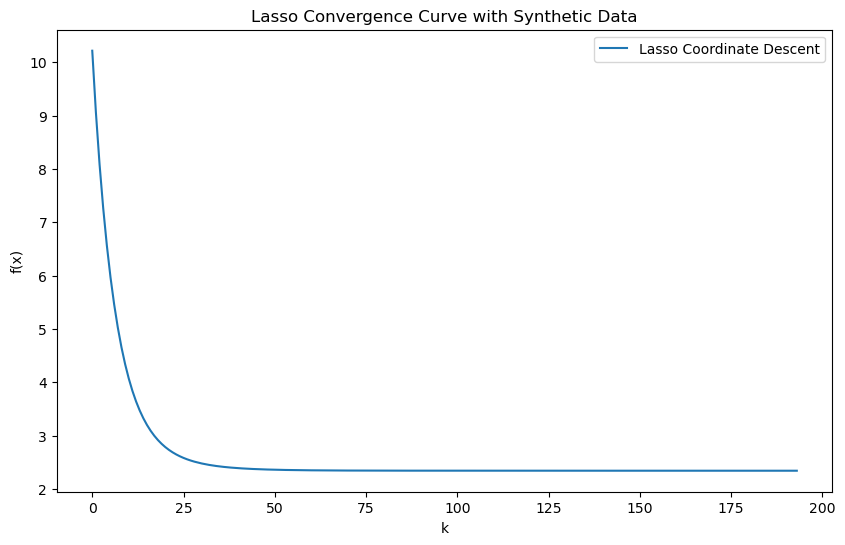

In [36]:
# Initialize and fit the Lasso model
lasso_CG = LassowithCG(alpha=0.1, max_iter=1000, tol=1e-4)

t0=time.time()
lasso_CG.fit(X, Y)
run_time_CG=time.time()-t0

# Plot the convergence curve
plt.figure(figsize=(10, 6))
plt.plot(lasso_CG.objectives_, label='Lasso Coordinate Descent')
plt.xlabel('k')
plt.ylabel('f(x)')
plt.title('Lasso Convergence Curve with Synthetic Data')
plt.legend()
plt.show()

In [37]:
lasso_CG.objectives_

[10.215051584122934,
 9.056300654514542,
 8.087185363302886,
 7.263717204966501,
 6.563366415332416,
 5.96722957399569,
 5.459356996725757,
 5.026284958826633,
 4.656643245636209,
 4.34082525404853,
 4.070710600714908,
 3.8394318171247495,
 3.6411780689956847,
 3.4710299751805636,
 3.3248205551666348,
 3.199018133962631,
 3.090627703691949,
 2.997107803447369,
 2.916300450443008,
 2.846372050912062,
 2.785763550855896,
 2.7331483649674304,
 2.687396855475036,
 2.647546328526304,
 2.612775680124617,
 2.582383961631811,
 2.5557722507196825,
 2.532428310963387,
 2.5119136050138264,
 2.4938522949722404,
 2.477921921320682,
 2.463845500298675,
 2.451384820436222,
 2.440334753294642,
 2.4305184223675123,
 2.421783098425123,
 2.41399671007715,
 2.407044875592636,
 2.4008283765674303,
 2.3952610062986035,
 2.3902677360748403,
 2.3857831513256684,
 2.3817501169458155,
 2.3781186373386,
 2.3748448819843646,
 2.3718903517881453,
 2.3692211652225383,
 2.36680744646433,
 2.3646228004172327,
 2.3626

In [10]:
class SubGradient(object):
    def __init__(self, A, b, mu, iteration=1000, tol=1e-9):
        self.x = None
        self.A = A
        self.m, self.n = self.A.shape
        self.q = np.dot(A.T, A)
        self.step_size = 1.0 / np.linalg.norm(self.q, 2)

        self.b = b
        self.Atb = np.dot(A.T, self.b)
        self.mu = mu

        self.iteration = iteration
        self.obj_path = [1]
        self.tol = tol
        self.initers = 0
        self.iters = 0
        self.run_time = 0

    def loss(self, x):
        x = x.reshape(-1)
        return 0.5 * np.sum(np.square(np.dot(self.A, x) - self.b)) + self.mu * np.sum(np.abs(x))

    def fix_step(self, mu, x):
        g = np.dot(self.q, x) - self.Atb + np.sign(x) * mu
        x -= self.step_size * g
        return x

    def dimish_step(self, mu, x, iter):
        g = np.dot(self.q, x) - self.Atb + np.sign(x) * mu
        x -= self.step_size / iter * g
        return x

    def lenth_step(self, mu, x):
        g = np.dot(self.q, x) - self.Atb + np.sign(x) * mu
        x -= self.step_size / np.linalg.norm(g) * g
        return x

    def train(self):
        t0 = time.time()
        x = np.zeros(self.n)
        print("subgradient method begins")
        self.initers = 0
        for hot_mu in [1e3, 1e2, 1e1, 1e-1, 1e-2, 1e-3]:
            err_rate = 1.0
            in_iter = 1
            while err_rate > self.tol and in_iter < self.iteration:
                x = self.fix_step(hot_mu, x)
                self.obj_path.append(self.loss(x))
                err_rate = np.abs(self.obj_path[-1] - self.obj_path[-2]) / self.obj_path[-2]
                in_iter += 1
            self.initers += in_iter

        self.iters = 1
        err_rate = 1.0
        while err_rate > self.tol:
            x = self.dimish_step(self.mu, x, self.iters)
            self.obj_path.append(self.loss(x))
            err_rate = np.abs(self.obj_path[-1] - self.obj_path[-2]) / self.obj_path[-2]
            self.iters += 1

        self.x = x
        self.run_time = time.time() - t0
        print("subgradient obj: {: >4.9f}/ time: {: >4.4f} /initers: {}/ iters: {}".format(self.obj_path[-1],
                                                                                           self.run_time,
                                                                                           self.initers,
                                                                                           self.iters))

subgradient method begins
subgradient obj: 2.353513947/ time: 0.3864 /initers: 6000/ iters: 30535


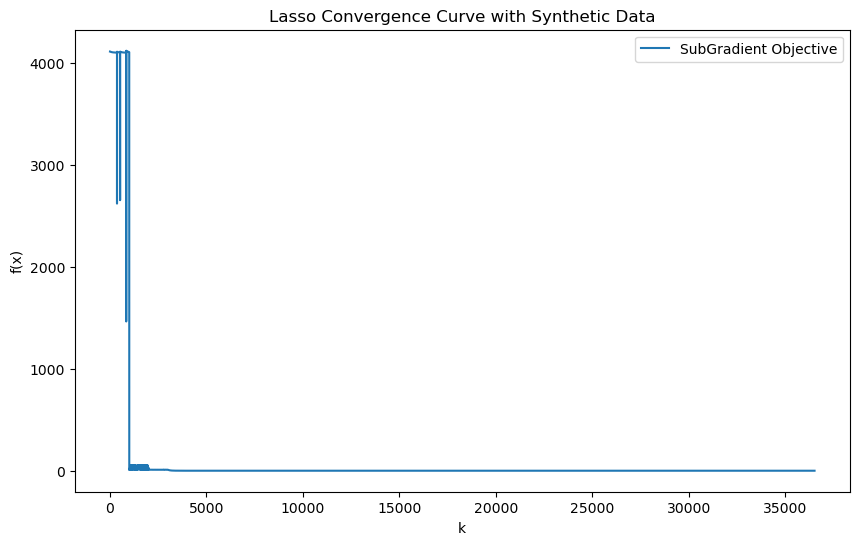

In [52]:
subgrad = SubGradient(X, Y, mu=0.1, iteration=1000)

t0=time.time()
subgrad.train()
run_time_subgrad=time.time()-t0

# plot
plt.figure(figsize=(10, 6))
plt.plot(subgrad.obj_path[2:], label='SubGradient Objective') 
plt.xlabel('k')
plt.ylabel('f(x)')
plt.title('Lasso Convergence Curve with Synthetic Data')
plt.legend()
plt.show()

In [51]:
subgrad.obj_path[2:10]

[4111.848088446432,
 4112.020097245703,
 4111.652941886048,
 4111.824835811962,
 4111.461536518525,
 4111.633298338927,
 4111.273796651493,
 4111.4454097053285]

In [12]:
class LassowithProxGradient:
    def __init__(self,  A, b, mu, init_iteration=100, max_iteration=2000, tol=1e-8):
        self.x = None
        self.A = A
        self.m, self.n = self.A.shape
        self.q = np.dot(A.T, A)
        self.step_size = 1.0 / np.linalg.norm(self.q, 2)

        self.b = b
        self.Atb = np.dot(self.A.T, self.b)
        self.mu = mu

        self.init_iteration = init_iteration
        self.max_iteration = max_iteration
        self.obj_path = [1]
        self.tol = tol
        self.iters = 1
        self.run_time = 0

    def loss(self, x):
        x = x.reshape(-1)
        return 0.5 * np.sum(np.square(np.dot(self.A, x) - self.b)) + self.mu * np.sum(np.abs(x))

    @staticmethod
    def prox(x, num):
        def pointwise_prox(u, t):
            if u >= t:
                return u - t
            elif u <= -t:
                return u + t
            else:
                return 0.0
        return np.vectorize(pointwise_prox)(x, num)

    def basic_step(self, mu, x):
        g = np.dot(self.q, x) - self.Atb
        x = x - self.step_size * g
        x = self.prox(x, mu * self.step_size)
        return x

    def fast_step(self, mu, x, x_, k):
        # we could reformulate FISTA in a nesterov-like form involving x and v
        y = x + 1.0 * (k - 2)/(k + 1) * (x - x_)
        x_ = x.copy()
        g = np.dot(self.q, y) - self.Atb
        x = y - self.step_size * g
        x = self.prox(x, mu * self.step_size)
        return x, x_

    def nesterov_step(self, mu, x, v, k):
        theta = 2.0 / (k + 1)
        y = (1.0 - theta) * x + theta * v
        g = np.dot(self.q, y) - self.Atb
        tmp = v - self.step_size / theta * g
        v = self.prox(tmp, mu * self.step_size / theta)
        x = (1.0 - theta) * x + theta * v
        return x, v

    def train(self, mode="Basic"):
        t0 = time.time()

        x = np.random.normal(size=self.n)
        print("{} proximal gradient begins".format(mode))
        self.initers = 0
        hot_mus = [1e3, 1e2, 1e1, 1e-1, 1e-2, 1e-3]
        if mode == 'Basic':
            for i in range(len(hot_mus)):
                err_rate = 1.0
                in_iter = 1
                while err_rate > 10**(-5-i) and in_iter < self.max_iteration:
                    x = self.basic_step(hot_mus[i], x)
                    self.obj_path.append(self.loss(x))
                    err_rate = np.abs(self.obj_path[-1] - self.obj_path[-2]) / self.obj_path[-2]
                    in_iter += 1
                self.initers += in_iter

            self.iters = 1
            err_rate = 1.0
            while err_rate > self.tol and self.initers < self.max_iteration:
                x = self.basic_step(self.mu, x)
                self.obj_path.append(self.loss(x))
                err_rate = np.abs(self.obj_path[-1] - self.obj_path[-2]) / self.obj_path[-2]
                print(err_rate)
                self.iters += 1

        elif mode == 'FISTA':
            x_ = x.copy()
            for i in range(len(hot_mus)):
                err_rate = 1.0
                in_iter = 1
                while err_rate > 10**(-5-i) and in_iter < self.init_iteration:
                    x, x_ = self.fast_step(hot_mus[i], x, x_, in_iter)
                    self.obj_path.append(self.loss(x))
                    err_rate = np.abs(self.obj_path[-1] - self.obj_path[-2]) / self.obj_path[-2]
                    in_iter += 1
                self.initers += in_iter

            self.iters = 1
            err_rate = 1.0
            while err_rate > self.tol and self.iters < self.max_iteration:
                x, x_ = self.fast_step(self.mu, x, x_, self.iters)
                self.obj_path.append(self.loss(x))
                err_rate = np.abs(self.obj_path[-1] - self.obj_path[-2]) / self.obj_path[-2]
                self.iters += 1

        elif mode == 'Nesterov':
            v = x.copy()
            for i in range(len(hot_mus)):
                err_rate = 1.0
                in_iter = 1
                while err_rate > 10**(-5-i) and in_iter < self.init_iteration:
                    x, v = self.nesterov_step(hot_mus[i], x, v, in_iter)
                    self.obj_path.append(self.loss(x))
                    err_rate = np.abs(self.obj_path[-1] - self.obj_path[-2]) / self.obj_path[-2]
                    in_iter += 1
                self.initers += in_iter

            self.iters = 1
            err_rate = 1.0
            while err_rate > self.tol and self.max_iteration:
                x, v = self.nesterov_step(self.mu, x, v, self.iters)
                self.obj_path.append(self.loss(x))
                err_rate = np.abs(self.obj_path[-1] - self.obj_path[-2]) / self.obj_path[-2]
                self.iters += 1

        else:
            raise ValueError("No {} mode. Choose modes from Basic(Default), FISTA or Nesterov")

        self.x = x
        self.run_time = time.time() - t0
        print("{:s} proximal gradient obj: {: >4.9f}/ time: {: >4.4f} /initers: {}/ iters: {}".format(mode,
                                                                                                      self.obj_path[-1],
                                                                                                      self.run_time,
                                                                                                      self.initers,
                                                                                                      self.iters))

Basic proximal gradient begins
Basic proximal gradient obj: 2.358819703/ time: 0.1060 /initers: 3837/ iters: 1


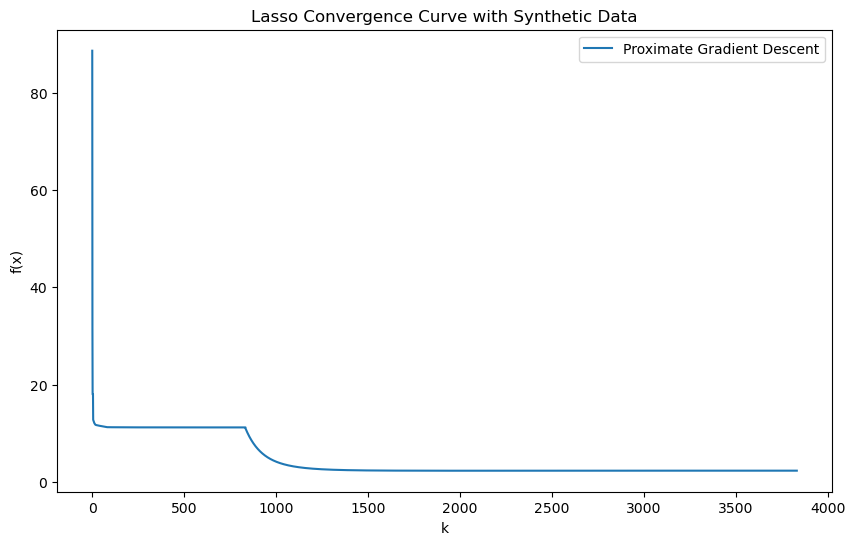

In [13]:
lasso_pgd = LassowithProxGradient(X, Y, mu=0.1, init_iteration=10, max_iteration=1000, tol=0.001)

t0=time.time()
lasso_pgd.train()
run_time_pgd=time.time()-t0

# plot
plt.figure(figsize=(10, 6))
plt.plot(lasso_pgd.obj_path[1:], label='Proximate Gradient Descent') 
plt.xlabel('k')
plt.ylabel('f(x)')
plt.title('Lasso Convergence Curve with Synthetic Data')
plt.legend()
plt.show()

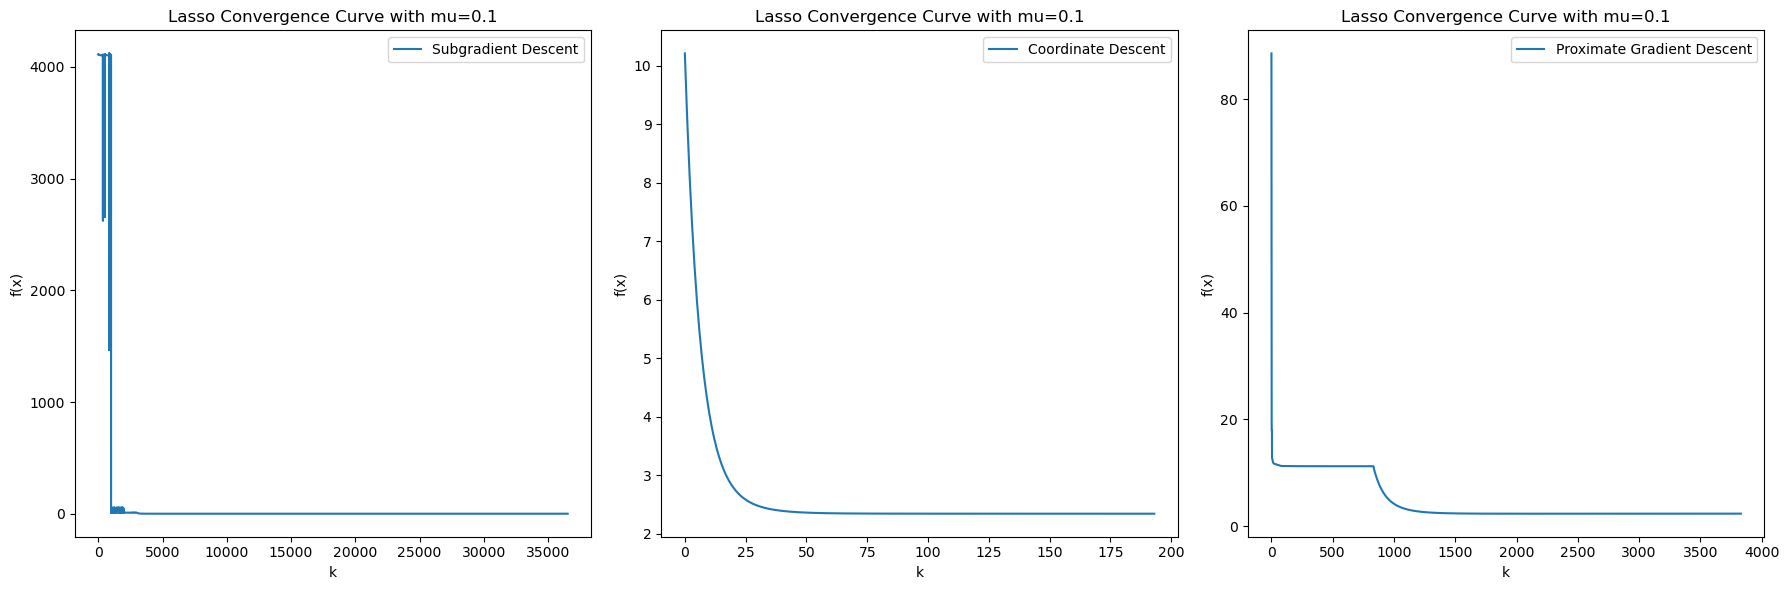

In [53]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6)) 

axs[0].plot(subgrad.obj_path[2:], label='Subgradient Descent')
axs[0].set_xlabel('k')
axs[0].set_ylabel('f(x)')
axs[0].set_title('Lasso Convergence Curve with mu=0.1')
axs[0].legend()

axs[1].plot(lasso_CG._objectives, label='Coordinate Descent')
axs[1].set_xlabel('k')
axs[1].set_ylabel('f(x)')
axs[1].set_title('Lasso Convergence Curve with mu=0.1')
axs[1].legend()

axs[2].plot(lasso_pgd.obj_path[1:], label='Proximate Gradient Descent')
axs[2].set_xlabel('k')
axs[2].set_ylabel('f(x)')
axs[2].set_title('Lasso Convergence Curve with mu=0.1')
axs[2].legend()

plt.tight_layout()
plt.show()

In [15]:
list=(run_time_subgrad,run_time_CG,run_time_pgd)
list

(0.506633996963501, 0.010000467300415039, 0.10702157020568848)